# Part 1: 1D Convolution

## 1a:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def rect(x, start, end):
    return np.where((x >= start) & (x <= end), 1, 0)

def plot_rect_signal(start, end, title):
    x = np.linspace(-10, 10, 1000)  
    y = rect(x, start, end) 

    plt.plot(x, y)
    plt.xlabel('x')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.grid(True)
    plt.show()

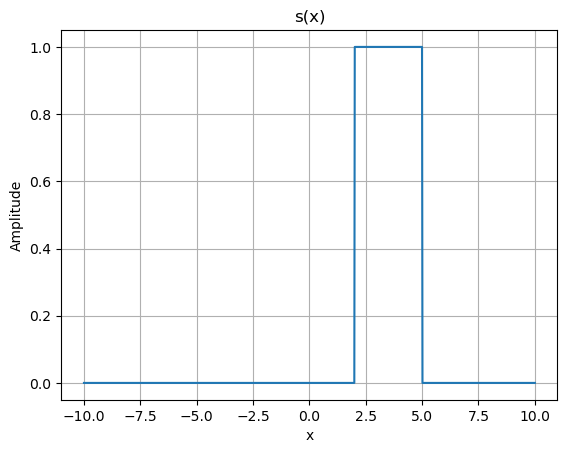

In [2]:
plot_rect_signal(2, 5, 's(x)')

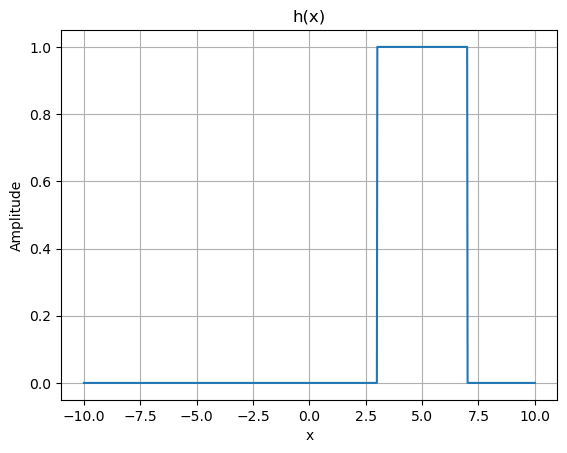

In [3]:
plot_rect_signal(3, 7, 'h(x)')

## 1b
Negating the x-component of a function "flips" the function along the y-axis. In the case of $h(x)$, it would create a rectangle signal from -7 to -3.

## 1c
Consider $h(x)$ flipped along the y-axis and "moving" along the x-axis. The product of the two functions is 0 whenever either of them are 0, so our convolution integral is only non-zero when both functions are non-zero. We can then split this into a piecewise function: where the two rectangles do not overlap at all, where the rectangles are overlapping but not fully overlapping, and where one is fully inside the other (fully overlapping). We handle each of these in turn:

1. When the rectangles are not overlapping at all, the product of the two functions is 0.
2. When the rectangles are not fully overlapping, we have the length of the overlapping area (the base) times the height. We can express this in terms of $x$, which increases linearly from 0 at $x=0$ until it reaches its maximum value of 3 at the point when the two fully overlap at $x=3$. The slope of this line is thus $\frac{1}{3}$ and its equation is $f(x) = \frac{x}{3}$. Similarly when $h(x)$ is moving past the two, we have this line with negative slope.
3. When they are fully overlapping, we have the area of the smaller rectangle ($3 \times 1 = 2$).

In summary we have $(s*h)(x) = \begin{cases} 0 & \text{if } x < 0 \\ \frac{x}{3} & \text{if } 0 \leq x < 3 \\ 3 & \text{if } 3 \leq x < 5 \\ \frac{-x}{3} & \text{if } 5 \leq x < 8 \\ 0 & \text{otherwise}\end{cases}$

# Part 2

In [4]:
def make_circle(cent: tuple, rad: int) -> np.ndarray:
    """
    Circle function from assisngment 1
    :param cent: center of the circle as [x, y]
    :param rad: radius of the circle
    :return: a logical mask (type int) with value 1 if the defined circle is in the
    boundaries and 0 if not
    """
    # Create a 101x101 array with zeros
    image = np.zeros((101, 101), dtype=int)
    # Generate coordinates for the circle
    y, x = np.ogrid[:101, :101]
    dist_from_center = np.sqrt((x - cent[0]) ** 2 + (y - cent[1]) ** 2)
    # Set values inside the circle to 1
    image[dist_from_center <= rad] = 1
    return image


def make_rgb_circle(center, radius, color):
    """
    Create a 3-channel colored circle.

    Parameters:
        center (tuple): Center coordinates of the circle (x, y).
        radius (int): Radius of the circle.
        color (str): Hex code for the RGB color of the circle.

    Returns:
        numpy.ndarray: 3-channel colored circle.
    """
    circle_mask = make_circle(center, radius)
    
    rgb_color = tuple(int(color[i:i+2], 16) for i in (0, 2, 4))
    colored_circle = np.zeros((101, 101, 3), dtype=int)
    colored_circle[circle_mask == 1] = rgb_color
    
    return colored_circle

In [5]:
center_1 = (35, 50)
center_2 = (65, 50)

radius = 11
color = 'FF0000'  # Red

rgb_circle_1 = make_rgb_circle(center_1, radius, color)
rgb_circle_2 = make_rgb_circle(center_2, radius, color)
image = rgb_circle_1 + rgb_circle_2

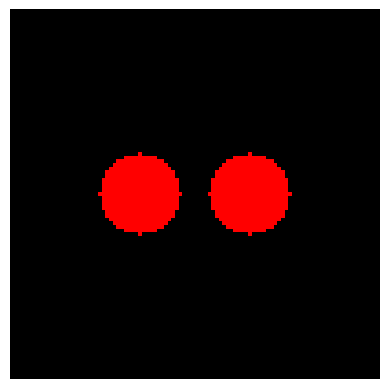

In [6]:
plt.figure()
plt.imshow(image)
plt.axis('off')
plt.show()

In [7]:
import math
from scipy.special import jn
def generate_2d_psf(wavelength: int):
    lambda_ = wavelength * 1e-9  # Fluorescence wavelength in nm
    ka = 2 * math.pi / lambda_
    Na = 1.3                     # Numerical aperture
    M = 28.8                     # Lens magnification
    Mt = 28.8                    # Lateral magnification
    Noil0 = 1.515
    Noil = 1.515
    OTL0  = 160e-3
    OTL = 160e-3
    Tspec = 0
    Nspec = 1.3
    Toil0 = 0.75e-3
    Tglass = 0.17e-3
    Tglass0 = 0.17e-3
    Nglass0 = 1.522
    Nglass = 1.522

    psf = np.zeros((16, 16), dtype=float)
    xc = 8
    yc = 8
    z = 0e-6

    delta = 0.001
    N = 1000

    Oil = Noil * Noil
    DZ1 = Noil
    Tube1 = ((OTL0 - OTL) * OTL0) / (((Mt * Mt) - (Na * Na)) * OTL)
    Tube2 = Tube1 / (2 * Noil)

    S1 = Tspec
    S2 = Nspec * Nspec
    S3 = Noil / Nspec
    S4 = Nspec - ((Noil * Noil) / Nspec)

    Oil1 = 0 if (Noil == Noil0) else Toil0
    Oil2 = Noil0 * Noil0
    Oil3 = Noil/Noil0
    Oil4 = Noil0 - ((Noil*Noil)/Noil0)

    TTglass = Tglass
    TTglass0 = Tglass0
    G1 = Noil / Nglass0
    G2 = Nglass * Nglass
    G3 = Nglass0 * Nglass0
    G4 = Noil / Nglass
    G5 = (Tglass * Nglass) - (Tglass0 * Nglass0) - (Noil * Noil * ((Tglass / Nglass) - (Tglass0 / Nglass0)))

    rho = np.linspace(0, 1, N)
    
    for i in range(16):
        for j in range(16):
            sumr = 0
            sumi = 0
            dist =  (math.floor(math.sqrt(((i-xc)**2)+((j-yc)**2))))*10**(-6)
            for l in range(N-1):
                rhoav = (rho[l-1]+rho[l])/2
                index = ((ka*Na*rhoav*dist)/M)
                temp = math.sqrt(Oil-(rhoav**2))
                a = (z+Tube1)*(temp-DZ1)
                b = Tube2*(rhoav**2)
                c = S1*(math.sqrt(S2-(rhoav**2))-(S3*temp)-S4)
                d = Oil1*(math.sqrt(Oil2-(rhoav**2))-(Oil3*temp)-Oil4)
                e = TTglass*(math.sqrt(G2-(rhoav**2))-(G4*temp))
                f = TTglass0*(math.sqrt(G3-(rhoav**2))-(G1*temp))
                g = G5
                phi = a+b+c-d+e-f-g
                bessout = jn(0,index)*rhoav*delta  # bessel function of first order, implemented by scipy
                addr = bessout*math.cos(ka*phi)
                sumr = sumr+addr
                addi = bessout*math.sin(ka*phi)
                sumi = sumi+addi
            #print(np.abs(sumr + sumi)**2)
            psf[i,j]=(np.abs(sumr+sumi))**2
    psf = (1/np.sum(np.sum(psf))) * psf
    return psf

In [8]:
from scipy.signal import convolve2d

def convolve_image_with_psf(image, psf):
    num_channels = image.shape[-1]
    psf_height, psf_width = psf.shape

    convolved_image = np.zeros_like(image)

    for channel in range(num_channels):
        image_channel = image[:, :, channel]
        convolved_channel = convolve2d(image_channel, psf, mode='same', boundary='symm')
        convolved_image[:, :, channel] = convolved_channel

    return convolved_image

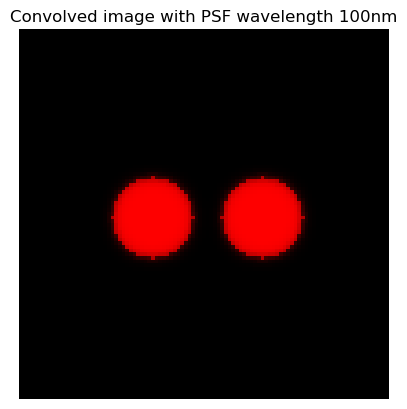

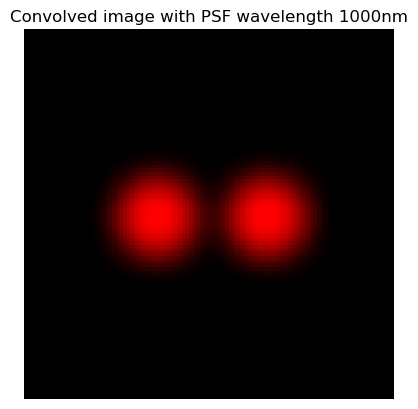

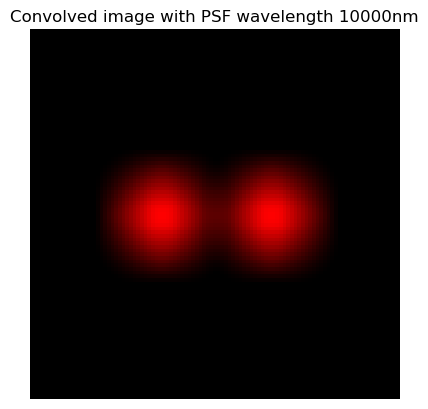

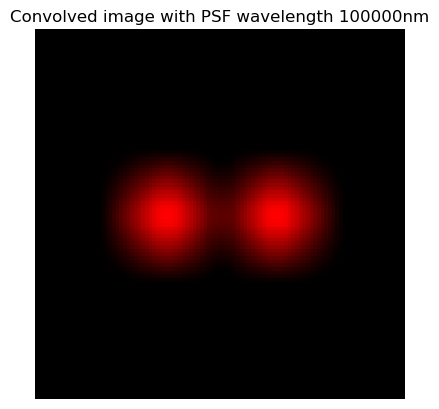

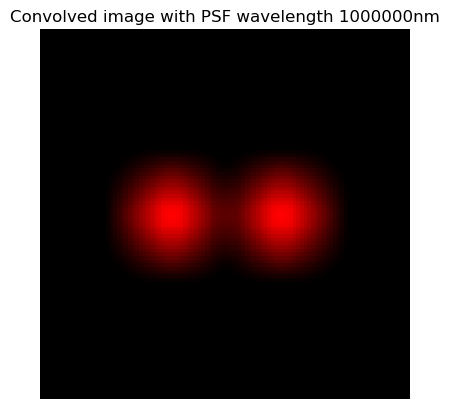

In [9]:
first_wavelength = 100
wavelengths = [first_wavelength * 10 ** i for i in range(5)]
for wavelength in wavelengths:
    plt.figure()
    psf = generate_2d_psf(wavelength)
    convolved_image = convolve_image_with_psf(image, psf)
    plt.title(f"Convolved image with PSF wavelength {wavelength}nm")
    plt.axis('off')
    plt.imshow(convolved_image)

The two circles start to blend together around wavelength 10000nm